# Predicting Monetary Policy Changes using NLP

## Step 5: modeling with text and economic data

Goals of this notebook:
+ Create and improve specific dictionaries
+ Build a sentiment indicator of monetary policy
+ Asses if there is a relationship between target and net sentiment

In [227]:
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import datetime as dt
from functools import reduce


# Import NLP modules
import re
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy

data_path = '/home/renatovassallo/Omega/BSE/Term2/Textmining/term_paper/full_analysis/data'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/renatovassallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Merge text to the economic dataframe

### Peru

In [228]:
df_text_peru = pd.read_csv(data_path+'/text_sentiment_data_per.csv')
df_economic_peru = pd.read_csv(data_path+'/nontext_data_peru.csv')
df_peru = pd.merge(df_text_peru, df_economic_peru, left_index=True, right_index=True) # Drop missing values
df_peru['date'] = df_peru.index
df_peru['country'] = 1
df_peru

statement  \
2004-01-01  Nota-Informativa-001-2004-BCRP.pdf   
2004-02-01  Nota-Informativa-002-2004-BCRP.pdf   
2004-03-01  Nota-Informativa-005-2004-BCRP.pdf   
2004-04-01  Nota-Informativa-009-2004-BCRP.pdf   
2004-05-01  Nota-Informativa-011-2004-BCRP.pdf   
...                                        ...   
2022-08-01   nota-informativa-2022-08-11-1.pdf   
2022-09-01   nota-informativa-2022-09-08-1.pdf   
2022-10-01   nota-informativa-2022-10-06-1.pdf   
2022-11-01   nota-informativa-2022-11-10-1.pdf   
2022-12-01   nota-informativa-2022-12-07-1.pdf   

                                                         text   tone_LM  \
2004-01-01  Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...  0.215517   
2004-02-01  Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...  0.239234   
2004-03-01  Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...  0.952381   
2004-04-01  Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...  0.000000   
2004-05-01  Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...  0.000000   
...                                                       ...       ...   
2022-08-01  NOTA INFORMATIVA PROGRAMA MONETARIO DE AGOSTO ...  0.000000   
2022-09-01  NOTA INFORMATIVA PROGRAMA MONETARIO DE SETIEMB...  0.211864   
2022-10-01  NOTA INFORMATIVA PROGRAMA MONETARIO DE OCTUBRE...  0.649351   
2022-11-01  NOTA INFORMATIVA PROGRAMA MONETARIO DE NOVIEMB...  0.662252   
2022-12-01  NOTA INFORMATIVA PROGRAMA MONETARIO DE DICIEMB...  0.622407   

              tone_GT                                          tokenized  \
2004-01-01   4.347826  ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-02-01   9.090909  ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-03-01  22.727273  ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-04-01   4.545455  ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-05-01   0.000000  ['mantener', 'tasa', 'interés', 'referencia', ...   
...               ...                                                ...   
2022-08-01  20.000000  ['elevar', 'tasa', 'interés', 'referencia', 'b...   
2022-09-01  20.000000  ['elevar', 'tasa', 'interés', 'referencia', 'b...   
2022-10-01  24.000000  ['elevar', 'tasa', 'interés', 'referencia', 'b...   
2022-11-01  20.000000  ['elevar', 'tasa', 'interés', 'referencia', 'b...   
2022-12-01  16.666667  ['elevar', 'tasa', 'interés', 'referencia', 'b...   

                                                    token_ids  \
2004-01-01  [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 11...   
2004-02-01  [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-03-01  [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-04-01  [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-05-01  [13, 3, 4, 105, 157, 74, 171, 183, 184, 185, 3...   
...                                                       ...   
2022-08-01  [264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...   
2022-09-01  [264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...   
2022-10-01  [264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...   
2022-11-01  [264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...   
2022-12-01  [264, 3, 4, 105, 173, 174, 548, 679, 768, 264,...   

                                               tokenized_text  \
2004-01-01  mantener tasa interés referencia índice precio...   
2004-02-01  mantener tasa interés referencia índice precio...   
2004-03-01  mantener tasa interés referencia índice precio...   
2004-04-01  mantener tasa interés referencia índice precio...   
2004-05-01  mantener tasa interés referencia índice precio...   
...                                                       ...   
2022-08-01  elevar tasa interés referencia banco central r...   
2022-09-01  elevar tasa interés referencia banco central r...   
2022-10-01  elevar tasa interés referencia banco central r...   
2022-11-01  elevar tasa interés referencia banco central r...   
2022-12-01  elevar tasa interés referencia banco central r...   

                     tfidf_negative  \
2004-01-01  [0. 0. 0.

In [229]:
df_peru.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 2004-01-01 to 2022-12-01
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   statement         228 non-null    object 
 1   text              228 non-null    object 
 2   tone_LM           228 non-null    float64
 3   tone_GT           228 non-null    float64
 4   tokenized         228 non-null    object 
 5   token_ids         228 non-null    object 
 6   tokenized_text    228 non-null    object 
 7   tfidf_negative    228 non-null    object 
 8   tfidf_positive    228 non-null    object 
 9   cos_sim_negative  228 non-null    float64
 10  cos_sim_positive  228 non-null    float64
 11  rate              228 non-null    float64
 12  target            228 non-null    float64
 13  prev_decision     228 non-null    float64
 14  next_decision     228 non-null    float64
 15  cpi_diff_year     228 non-null    float64
 16  infl_exp          228 non-null   

### Chile

In [230]:
df_text_chile = pd.read_csv(data_path+'/text_sentiment_data_chile.csv')
df_economic_chile = pd.read_csv(data_path+'/nontext_data_chile.csv')
df_economic_chile.rename(columns={"date": "date_econ"}, inplace=True)
min(df_economic_chile['date_econ'])
df_economic_chile['date_econ'] = pd.to_datetime(df_economic_chile['date_econ'])
df_economic_chile['month_year'] = df_economic_chile['date_econ'].dt.to_period('M')
df_economic_chile

date_econ       rate  target  prev_decision  next_decision  \
0   2003-01-01   2.818182      -1              0             -1   
1   2003-02-01   2.750000      -1             -1              0   
2   2003-03-01   2.750000       0             -1              0   
3   2003-04-01   2.750000       0              0              0   
4   2003-05-01   2.750000       0              0              0   
..         ...        ...     ...            ...            ...   
235 2022-08-01   9.750000       1              1              1   
236 2022-09-01  10.550000       1              1              1   
237 2022-10-01  11.065789       1              1              1   
238 2022-11-01  11.250000       1              1              0   
239 2022-12-01  11.250000       0              1              0   

     cpi_diff_year  infl_exp  unem_diff_year  gdp_diff_year month_year  
0         3.033243       3.0       -0.254760       4.249593    2003-01  
1         3.857509       3.0       -0.306373       5.392514    2003-02  
2         4.580894       3.0       -0.388684       4.947546    2003-03  
3         4.060073       3.0       -0.037171       4.511803    2003-04  
4         3.540293       2.9       -0.138289       5.512480    2003-05  
..             ...       ...             ...            ...        ...  
235      14.089877       7.3       -0.618166       0.342097    2022-08  
236      13.728129       7.0       -0.365587      -0.299000    2022-09  
237      12.812113       6.3       -0.108220      -0.849171    2022-10  
238      13.338032       5.8        0.421174      -2.118585    2022-11  
239      12.789580       5.3        0.672855      -0.951262    2022-12  

[240 rows x 10 columns]

In [231]:
#Chile

df_text_chile['date'] = pd.to_datetime(df_text_chile['date'])
df_text_chile_f = df_text_chile[df_text_chile.date > min(df_economic_chile['date_econ'])]
df_text_chile_f['month_year'] = df_text_chile_f['date'].dt.to_period('M')
df_text_chile_f.sort_values(by='month_year',ascending =True,inplace =True)

df_text_chile_f

/tmp/ipykernel_976/849425558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_chile_f['month_year'] = df_text_chile_f['date'].dt.to_period('M')
/tmp/ipykernel_976/849425558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text_chile_f.sort_values(by='month_year',ascending =True,inplace =True)


date                      statement  \
220 2003-01-09  bcch_comunicado_094804_es.pdf   
219 2003-02-18  bcch_comunicado_094803_es.pdf   
218 2003-03-13  bcch_comunicado_094802_es.pdf   
217 2003-04-08  bcch_comunicado_094801_es.pdf   
216 2003-05-08  bcch_comunicado_094800_es.pdf   
..         ...                            ...   
4   2022-07-13    comunicado-rpm-13072022.pdf   
3   2022-09-06     rpm_06_septiembre_2022.pdf   
2   2022-10-12        rpm_12_octubre_2022.pdf   
1   2022-12-06       rpm_6_diciembre_2022.pdf   
0   2023-01-26          rpm_26_enero_2023.pdf   

                                                  text   tone_LM    tone_GT  \
220   antiago. 9 de enero de 2003COMUCDOn  su  reun... -2.030457  20.000000   
219  antiago. 18 de febrero de 2003 COMUCDO  n su r...  0.571429  11.111111   
218    COMUCDO  antiago, 13 de marzo de 2003  n  su... -0.699301  14.285714   
217       antiago, 8 de abril de 2003.  Comunicado ... -0.507614   0.000000   
216    comunicado antiago, 8 de mayo de 2003.    n ...  0.000000  11.111111   
..                                                 ...       ...        ...   
4    Comunicado de Prensa    Miércoles 13 de julio ... -1.068702  11.428571   
3    Comunicado de Prensa    Martes 6 de septiembre...  0.167224  19.444444   
2    Comunicado de Prensa    Miércoles 12 de octubr... -0.189394  20.000000   
1    Comunicado de Prensa    Martes 6 de diciembre ... -0.982318   0.000000   
0    Comunicado de Prensa    Jueves 26 de enero de ...  0.000000   6.451613   

                                             tokenized  \
220  ['antiago', 'reunión', 'mensual', 'política', ...   
219  ['antiago', 'comucdo', 'reunión', 'mensual', '...   
218  ['comucdo', 'antiago', 'reunión', 'mensual', '...   
217  ['antiago', 'reunión', 'mensual', 'política', ...   
216  ['antiago', 'reunión', 'mensual', 'política', ...   
..                                                 ...   
4    ['miércoles', 'política', 'monetaria', 'políti...   
3    ['martes', 'política', 'monetaria', 'política'...   
2    ['miércoles', 'política', 'monetaria', 'políti...   
1    ['martes', 'política', 'monetaria', 'política'...   
0    ['política', 'monetaria', 'política', 'monetar...   

                                             token_ids  \
220  [1751, 641, 123, 1, 3, 4, 5, 1369, 412, 9, 10,...   
219  [1751, 978, 641, 123, 1, 3, 4, 5, 1369, 8, 9, ...   
218  [978, 1751, 641, 123, 1, 3, 4, 5, 1369, 8, 9, ...   
217  [1751, 641, 123, 1, 3, 4, 5, 1369, 13, 8, 9, 1...   
216  [1751, 641, 123, 1, 3, 4, 5, 1369, 13, 8, 9, 1...   
..                                                 ...   
4    [235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...   
3    [178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...   
2    [235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,...   
1    [178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ...   
0    [1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1...   

                                        tokenized_text  \
220  antiago reunión mensual política consejo banco...   
219  antiago comucdo reunión mensual política conse...   
218  comucdo antiago reunión mensual política conse...   
217  antiago reunión mensual política consejo banco...   
216  antiago reunión mensual política consejo banco...   
..                                                 ...   
4    miércoles política monetaria política monetari...   
3    martes política monetaria política monetaria c...   
2    miércoles política monetaria política monetari...   
1    martes política monetaria política monetaria c...   
0    política monetaria política monetaria consejo ...   

              tfidf_negative  \
220  [0. 0. 0. ... 0. 0. 0.]   
219  [0. 0. 0. ... 0. 0. 0.]   
218  [0. 0. 0. ... 0. 0. 0.]   
217  [0. 0. 0. ... 0. 0. 0.]   
216  [0. 0. 0. ... 0. 0. 0.]   
..                       ...   
4    [0. 0. 0. ... 0. 0. 0.]   
3    [0. 0. 0. ... 0. 0. 0.]   
2    [0. 0. 0. ... 0. 0. 0.]   
1    [0. 0. 0. ... 0. 0. 0.]   
0    [0. 0. 0. ... 0. 0. 0.] 

In [232]:
df_chile = pd.merge(df_text_chile_f,df_economic_chile,
                 on='month_year', 
                 how='left')
                 
df_chile = df_chile.set_index('date')
df_chile['country'] = 2
df_chile

statement  \
date                                        
2003-01-09  bcch_comunicado_094804_es.pdf   
2003-02-18  bcch_comunicado_094803_es.pdf   
2003-03-13  bcch_comunicado_094802_es.pdf   
2003-04-08  bcch_comunicado_094801_es.pdf   
2003-05-08  bcch_comunicado_094800_es.pdf   
...                                   ...   
2022-07-13    comunicado-rpm-13072022.pdf   
2022-09-06     rpm_06_septiembre_2022.pdf   
2022-10-12        rpm_12_octubre_2022.pdf   
2022-12-06       rpm_6_diciembre_2022.pdf   
2023-01-26          rpm_26_enero_2023.pdf   

                                                         text   tone_LM  \
date                                                                      
2003-01-09   antiago. 9 de enero de 2003COMUCDOn  su  reun... -2.030457   
2003-02-18  antiago. 18 de febrero de 2003 COMUCDO  n su r...  0.571429   
2003-03-13    COMUCDO  antiago, 13 de marzo de 2003  n  su... -0.699301   
2003-04-08       antiago, 8 de abril de 2003.  Comunicado ... -0.507614   
2003-05-08    comunicado antiago, 8 de mayo de 2003.    n ...  0.000000   
...                                                       ...       ...   
2022-07-13  Comunicado de Prensa    Miércoles 13 de julio ... -1.068702   
2022-09-06  Comunicado de Prensa    Martes 6 de septiembre...  0.167224   
2022-10-12  Comunicado de Prensa    Miércoles 12 de octubr... -0.189394   
2022-12-06  Comunicado de Prensa    Martes 6 de diciembre ... -0.982318   
2023-01-26  Comunicado de Prensa    Jueves 26 de enero de ...  0.000000   

              tone_GT                                          tokenized  \
date                                                                       
2003-01-09  20.000000  ['antiago', 'reunión', 'mensual', 'política', ...   
2003-02-18  11.111111  ['antiago', 'comucdo', 'reunión', 'mensual', '...   
2003-03-13  14.285714  ['comucdo', 'antiago', 'reunión', 'mensual', '...   
2003-04-08   0.000000  ['antiago', 'reunión', 'mensual', 'política', ...   
2003-05-08  11.111111  ['antiago', 'reunión', 'mensual', 'política', ...   
...               ...                                                ...   
2022-07-13  11.428571  ['miércoles', 'política', 'monetaria', 'políti...   
2022-09-06  19.444444  ['martes', 'política', 'monetaria', 'política'...   
2022-10-12  20.000000  ['miércoles', 'política', 'monetaria', 'políti...   
2022-12-06   0.000000  ['martes', 'política', 'monetaria', 'política'...   
2023-01-26   6.451613  ['política', 'monetaria', 'política', 'monetar...   

                                                    token_ids  \
date                                                            
2003-01-09  [1751, 641, 123, 1, 3, 4, 5, 1369, 412, 9, 10,...   
2003-02-18  [1751, 978, 641, 123, 1, 3, 4, 5, 1369, 8, 9, ...   
2003-03-13  [978, 1751, 641, 123, 1, 3, 4, 5, 1369, 8, 9, ...   
2003-04-08  [1751, 641, 123, 1, 3, 4, 5, 1369, 13, 8, 9, 1...   
2003-05-08  [1751, 641, 123, 1, 3, 4, 5, 1369, 13, 8, 9, 1...   
...                                                       ...   
2022-07-13  [235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...   
2022-09-06  [178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...   
2022-10-12  [235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,...   
2022-12-06  [178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ...   
2023-01-26  [1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1...   

                                               tokenized_text  \
date                                                            
2003-01-09  antiago reunión mensual política consejo banco...   
2003-02-18  antiago comucdo reunión mensual política conse...   
2003-03-13  comucdo antiago reunión mensual política conse...   
2003-04-08  antiago reunión mensual política consejo banco...   
2003-05-08  antiago reunión mensual política consejo banco...   
...                                                       ...   
2022-07-13  miércoles política monetaria política monetari...   
2022-09-06  martes política monetaria política mon

### Australia 

In [233]:
df_text_aus = pd.read_csv(data_path+'/text_sentiment_data_aus.csv')
df_economic_aus = pd.read_csv(data_path+'/nontext_data_aus.csv')
df_aus = pd.merge(df_text_aus,df_economic_aus, on='date', how='left')
df_aus['date'] = pd.to_datetime(df_aus['date'])
df_aus.sort_values(by='date', ascending=True, inplace=True)
df_aus = df_aus.set_index('date')
df_aus['country'] = 3
df_aus

text   tone_LM  \
date                                                                      
2008-02-01  Media Release\nStatement by Glenn Stevens, Gov... -2.008032   
2008-03-01  Media Release\nStatement by Glenn Stevens, Gov... -1.526718   
2008-04-01  Media Release\nStatement by Glenn Stevens, Gov... -2.745098   
2008-05-01  Media Release\nStatement by Glenn Stevens, Gov... -2.362205   
2008-06-01  Media Release\nStatement by Glenn Stevens, Gov... -1.680672   
...                                                       ...       ...   
2022-08-01  Media Release\nStatement by Philip Lowe, Gover... -0.252525   
2022-09-01  Media Release\nStatement by Philip Lowe, Gover... -1.873536   
2022-10-01  Media Release\nStatement by Philip Lowe, Gover... -1.507538   
2022-11-01  Media Release\nStatement by Philip Lowe, Gover... -0.483092   
2022-12-01  Media Release\nStatement by Philip Lowe, Gover... -1.315789   

              tone_GT                                          tokenized  \
date                                                                       
2008-02-01   0.000000  ['monetary', 'policy', 'at', 'meet', 'today', ...   
2008-03-01  -9.090909  ['monetary', 'policy', 'at', 'meet', 'today', ...   
2008-04-01  -4.761905  ['monetary', 'policy', 'at', 'meet', 'today', ...   
2008-05-01  -9.523810  ['monetary', 'policy', 'at', 'meet', 'today', ...   
2008-06-01 -15.789474  ['monetary', 'policy', 'at', 'meet', 'today', ...   
...               ...                                                ...   
2022-08-01  34.210526  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-09-01  32.558140  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-10-01  35.135135  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-11-01  34.146341  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-12-01  36.363636  ['monetary', 'policy', 'decision', 'at', 'meet...   

                                                    token_ids  \
date                                                            
2008-02-01  [1, 2, 3, 4, 5, 6, 7, 258, 9, 10, 11, 12, 13, ...   
2008-03-01  [1, 2, 3, 4, 5, 6, 7, 258, 9, 10, 11, 12, 13, ...   
2008-04-01  [1, 2, 3, 4, 5, 6, 7, 367, 9, 10, 368, 13, 14,...   
2008-05-01  [1, 2, 3, 4, 5, 6, 7, 367, 9, 10, 368, 13, 14,...   
2008-06-01  [1, 2, 3, 4, 5, 6, 7, 367, 9, 10, 368, 13, 14,...   
...                                                       ...   
2022-08-01  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-09-01  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-10-01  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-11-01  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-12-01  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   

                                               tokenized_text  \
date                                                            
2008-02-01  monetary policy at meet today board decide inc...   
2008-03-01  monetary policy at meet today board decide inc...   
2008-04-01  monetary policy at meet today board decide lea...   
2008-05-01  monetary policy at meet today board decide lea...   
2008-06-01  monetary policy at meet today board decide lea...   
...                                                       ...   
2022-08-01  monetary policy decision at meet today board d...   
2022-09-01  monetary policy decision at meet today board d...   
2022-10-01  monetary policy decision at meet today board d...   
2022-11-01  monetary policy decision at meet today board d...   
2022-12-01  monetary policy decision at meet today board d...   

                     tfidf_negative  \
date                                  
2008-02-01  [0. 0. 0. ... 0. 0. 0.]   
2008-03-01  [0. 0. 0. ... 0. 0. 0.]   
2008-04-01  [0. 0. 0. ... 0. 0. 0.]   
2008-05-01  [0. 0. 0. ... 0. 0. 0.]   
2008-06-01  [0. 0. 0. ... 0. 0. 0.]   
...                             ...   
2022-08-01  [0. 0. 0. ... 0. 0. 0.]   
2022-09-01  [0. 0. 0. ... 0. 0. 0.]   
2022-10-01

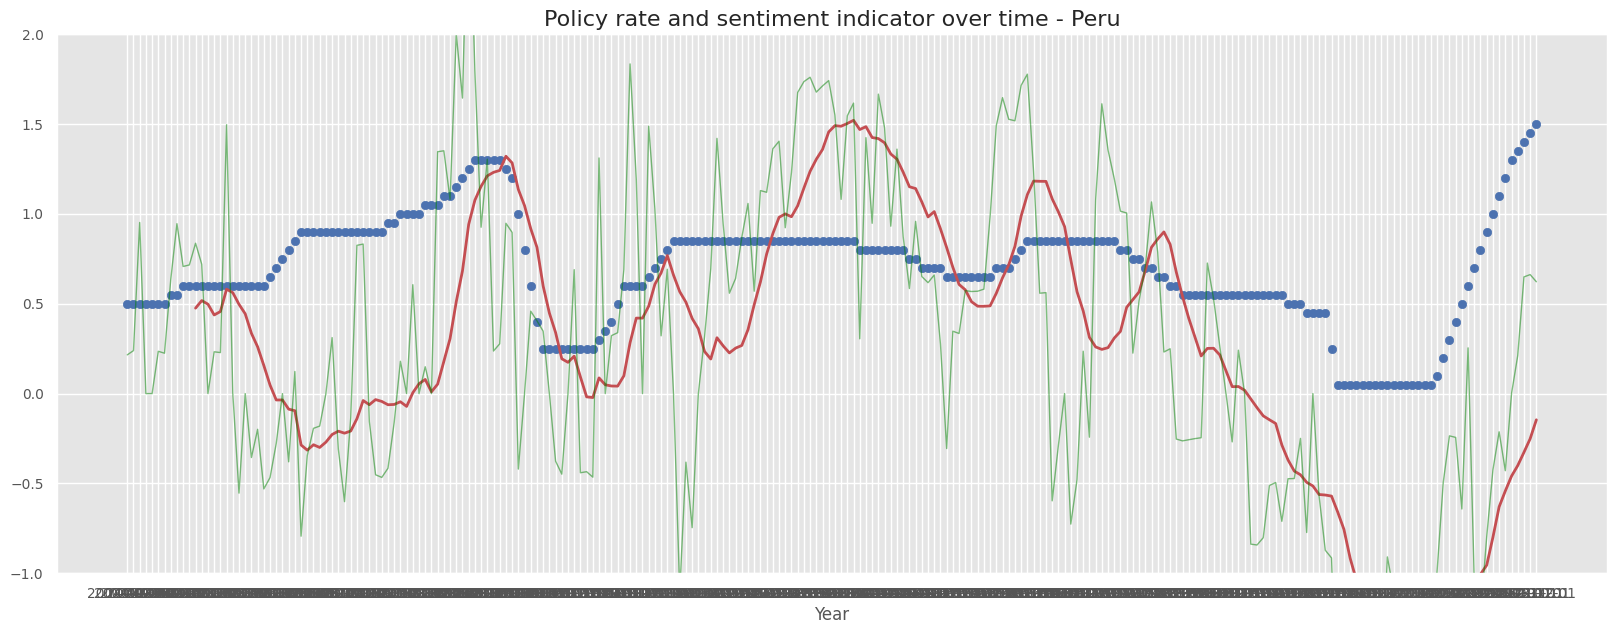

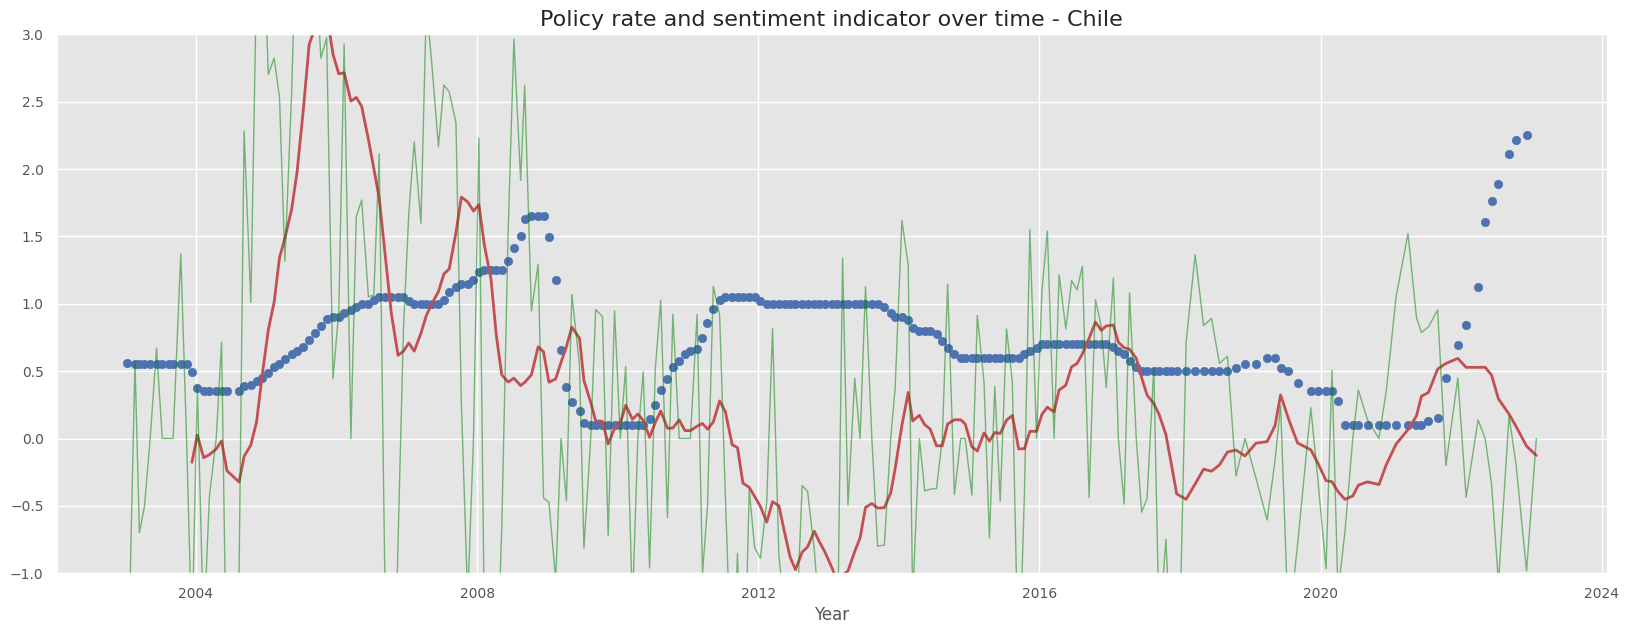

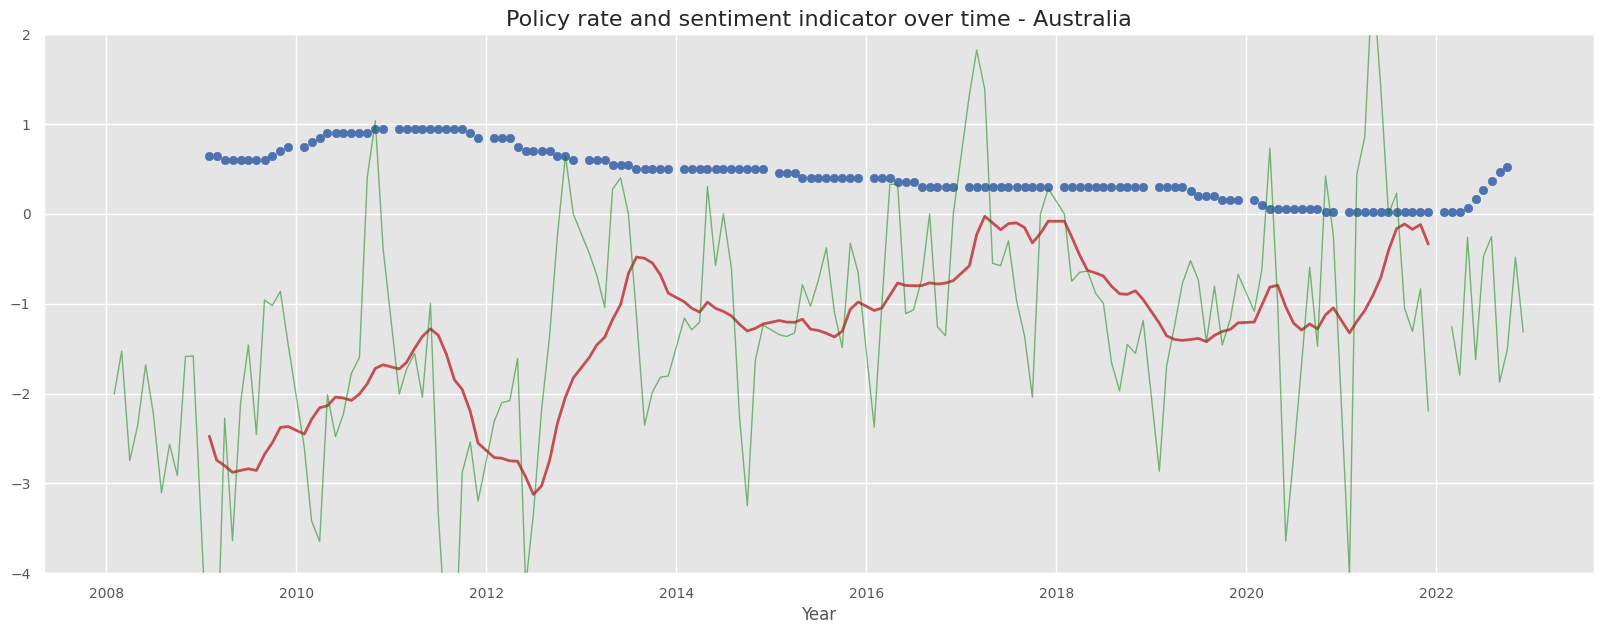

In [234]:
Window = 12

def plot(df,country,y_min_lim,y_max_lim):
    df['tone_ma_LM'] = df['tone_LM'].rolling(Window).mean()

    fig, ax = plt.subplots(figsize=(20,7))

    ax.scatter(df.index.values, df['rate']/5, c = 'b')
    ax.plot(df.index.values, df['tone_ma_LM'], c = 'r', linewidth= 2)
    ax.plot(df.index.values, df['tone_LM'], c = 'green', linewidth= 1, alpha = 0.5)
    ax.set_title('Policy rate and sentiment indicator over time - ' + country, fontsize=16)
    ax.set_xlabel('Year',fontsize=12)
    #ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylim(y_min_lim,y_max_lim)

    # Define the date format
    import matplotlib.dates as mdates
    from matplotlib.dates import DateFormatter
    import seaborn as sns

    # Handle date time conversions between pandas and matplotlib
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()

    #date_form = DateFormatter("%y")
    #ax.xaxis.set_major_formatter(date_form)

    return(fig, ax)

fig,ax = plot(df_peru,'Peru',-1,2)
fig,ax = plot(df_chile, 'Chile',-1,3)
fig,ax = plot(df_aus, 'Australia',-4,2)

#### Merge dataframe

In [213]:
df = pd.concat([df_peru,df_chile,df_aus])
df

statement  \
2004-01-01           Nota-Informativa-001-2004-BCRP.pdf   
2004-02-01           Nota-Informativa-002-2004-BCRP.pdf   
2004-03-01           Nota-Informativa-005-2004-BCRP.pdf   
2004-04-01           Nota-Informativa-009-2004-BCRP.pdf   
2004-05-01           Nota-Informativa-011-2004-BCRP.pdf   
...                                                 ...   
2022-06-01 00:00:00                                 NaN   
2022-05-01 00:00:00                                 NaN   
2022-04-01 00:00:00                                 NaN   
2022-03-01 00:00:00                                 NaN   
2022-02-01 00:00:00                                 NaN   

                                                                  text  \
2004-01-01           Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...   
2004-02-01           Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...   
2004-03-01           Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...   
2004-04-01           Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...   
2004-05-01           Nota de Prensa DIRECTORIO DEL BCR APROBÓ PROGR...   
...                                                                ...   
2022-06-01 00:00:00  Media Release\nStatement by Philip Lowe, Gover...   
2022-05-01 00:00:00  Media Release\nStatement by Philip Lowe, Gover...   
2022-04-01 00:00:00  Media Release\nStatement by Philip Lowe, Gover...   
2022-03-01 00:00:00  Media Release\nStatement by Philip Lowe, Gover...   
2022-02-01 00:00:00  Media Release\nStatement by Philip Lowe, Gover...   

                      tone_LM    tone_GT  \
2004-01-01           0.215517   4.347826   
2004-02-01           0.239234   9.090909   
2004-03-01           0.952381  22.727273   
2004-04-01           0.000000   4.545455   
2004-05-01           0.000000   0.000000   
...                       ...        ...   
2022-06-01 00:00:00 -1.620370  35.897436   
2022-05-01 00:00:00 -0.259740  29.411765   
2022-04-01 00:00:00 -1.794872  20.000000   
2022-03-01 00:00:00 -1.255230  13.953488   
2022-02-01 00:00:00       NaN        NaN   

                                                             tokenized  \
2004-01-01           ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-02-01           ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-03-01           ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-04-01           ['mantener', 'tasa', 'interés', 'referencia', ...   
2004-05-01           ['mantener', 'tasa', 'interés', 'referencia', ...   
...                                                                ...   
2022-06-01 00:00:00  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-05-01 00:00:00  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-04-01 00:00:00  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-03-01 00:00:00  ['monetary', 'policy', 'decision', 'at', 'meet...   
2022-02-01 00:00:00  ['monetary', 'policy', 'decision', 'at', 'meet...   

                                                             token_ids  \
2004-01-01           [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 11...   
2004-02-01           [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-03-01           [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-04-01           [13, 3, 4, 105, 157, 74, 171, 183, 184, 77, 3,...   
2004-05-01           [13, 3, 4, 105, 157, 74, 171, 183, 184, 185, 3...   
...                                                                ...   
2022-06-01 00:00:00  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-05-01 00:00:00  [1, 2, 117, 3, 4, 5, 6, 7, 258, 9, 10, 99, 11,...   
2022-04-01 00:00:00  [1, 2, 117, 3, 4, 5, 6, 7, 809, 9, 10, 99, 11,...   
2022-03-01 00:00:00  [1, 2, 117, 3, 4, 5, 6, 7, 809, 9, 10, 99, 11,...   
2022-02-01 00:00:00  [1, 2, 117, 3, 4, 5, 6, 7, 809, 9, 10, 99, 11,...   

                                                        tokenized_text  \
2004-01-01           mantener tasa interés referencia índice precio

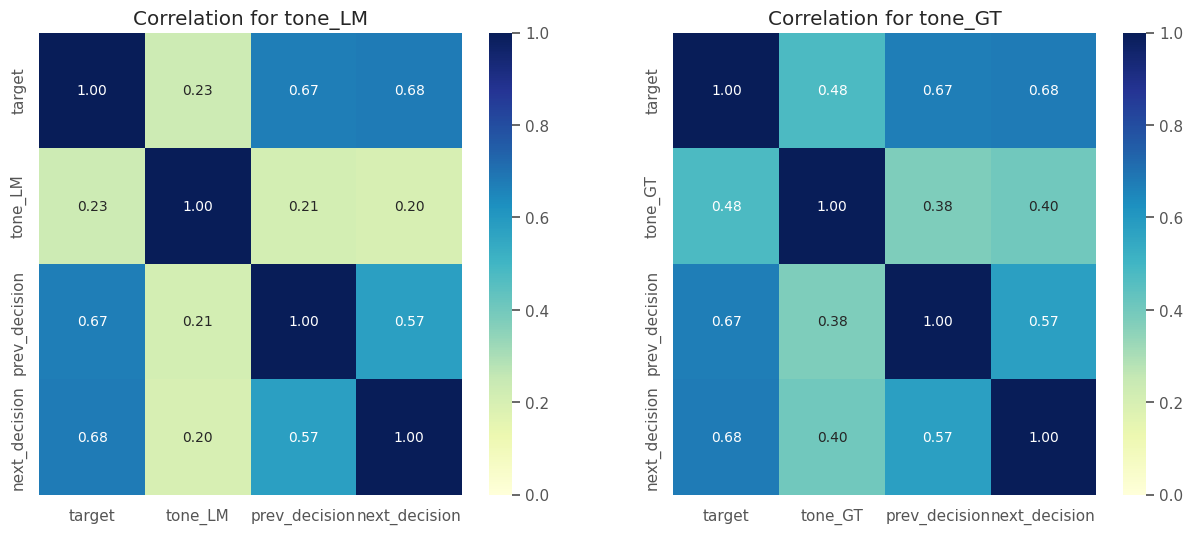

In [214]:
# Show corelations to next_decision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

corr_columns = ['target','tone_LM', 'prev_decision','next_decision']
sns.heatmap(df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation for tone_LM")

corr_columns = ['target', 'tone_GT', 'prev_decision','next_decision']
tmp_df = pd.DataFrame()
for column in corr_columns:
    tmp_df[column] = pd.to_numeric(df[column], errors='coerce')
sns.heatmap(tmp_df.astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation for tone_GT")

plt.show()

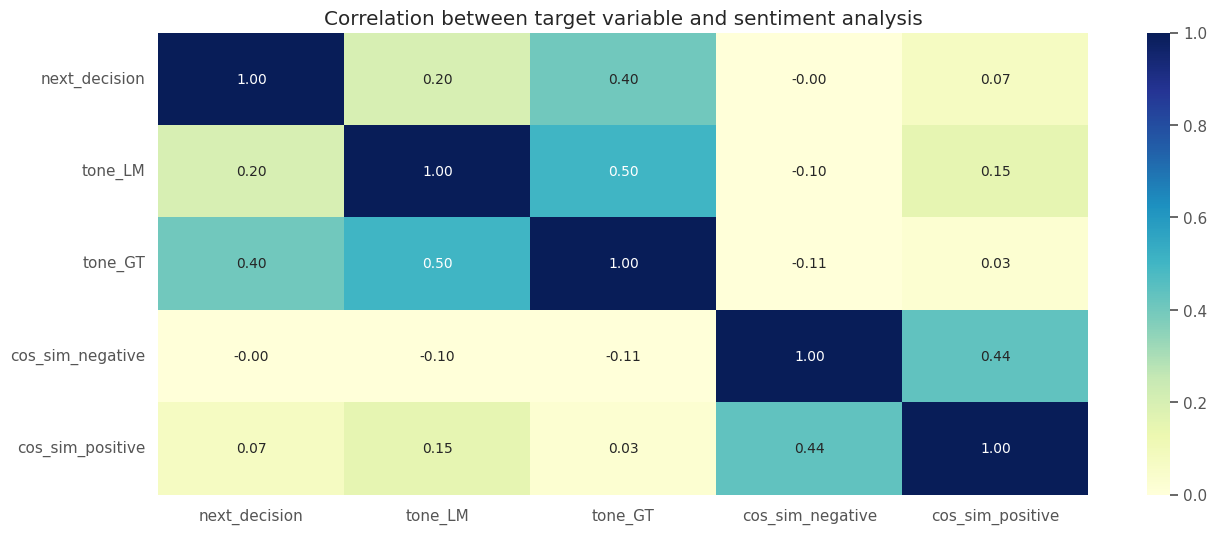

In [215]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['next_decision', 'tone_LM','tone_GT', 'cos_sim_negative', 'cos_sim_positive']
sns.heatmap(df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation between target variable and sentiment analysis")
plt.show()

### Convert target class for classification

In [216]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0
    
df['current_decision'] = df['target'].map(convert_class)
df['prev_decision'] = df['prev_decision'].map(convert_class)
df['target'] = df['next_decision'].map(convert_class)

## Modeling and Training

### Common functions

In [217]:
import seaborn as sns; sns.set()
plt.style.use('ggplot')
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

from collections import defaultdict
from collections import Counter
import datetime as dt
from tqdm.notebook import tqdm
import random

# Import Scikit-learn models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV

import scikitplot as skplt

In [218]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

# Set Random Seed
random.seed(123)
np.random.seed(123)
rand_seed = 123

In [219]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

#### Train and Test Data

In [220]:
df.columns

Index(['statement', 'text', 'tone_LM', 'tone_GT', 'tokenized', 'token_ids',
       'tokenized_text', 'tfidf_negative', 'tfidf_positive',
       'cos_sim_negative', 'cos_sim_positive', 'rate', 'target',
       'prev_decision', 'next_decision', 'cpi_diff_year', 'infl_exp',
       'unem_diff_year', 'gdp_diff_year', 'date', 'country', 'tone_ma_LM',
       'month_year', 'date_econ', 'current_decision'],
      dtype='object')

In [221]:
nontext_columns = ['current_decision', 'cpi_diff_year', 'infl_exp','unem_diff_year','gdp_diff_year','country']
text_columns = ['tone_LM','tone_GT', 'cos_sim_negative', 'cos_sim_positive']
target_column = ['target']

final_df = df[nontext_columns + text_columns + target_column]
final_df = final_df.dropna()

In [222]:
# X and Y data used
Y_data = final_df['target']
X_data = final_df[nontext_columns + text_columns]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

#### Grid Search setting

In [223]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=3, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    acc, f1 = metric(Y_test, pred_test)

    if plot:
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()

    return model

#### Train

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

Best Score:  0.6648816790376871
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1127}


/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/renatovassallo/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be rem

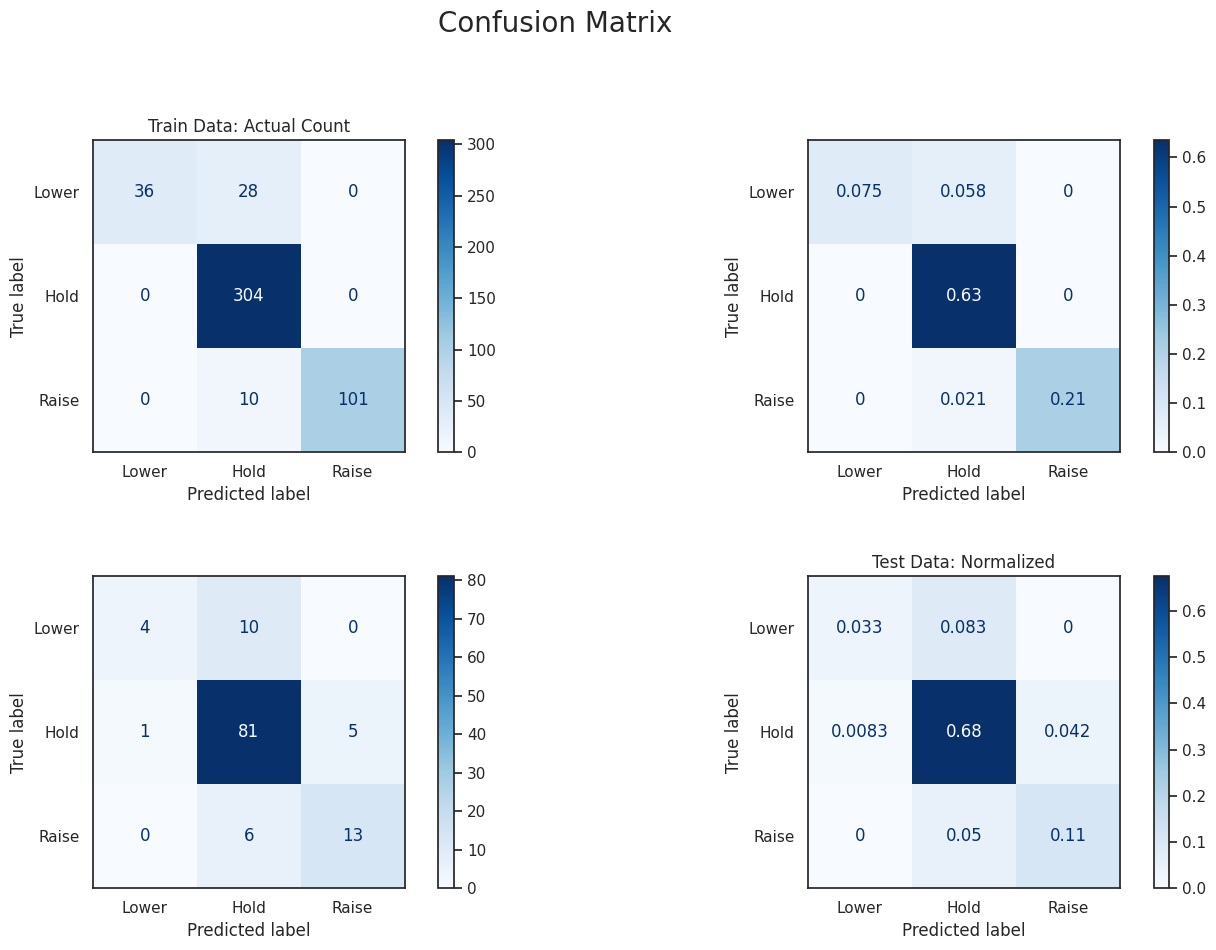

In [224]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto'],
              'max_depth': [2, 4, 6, 8],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

#Best Score:  0.6980567536071699
#Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 927}

Text(0.5, 1.0, 'Feature importance')

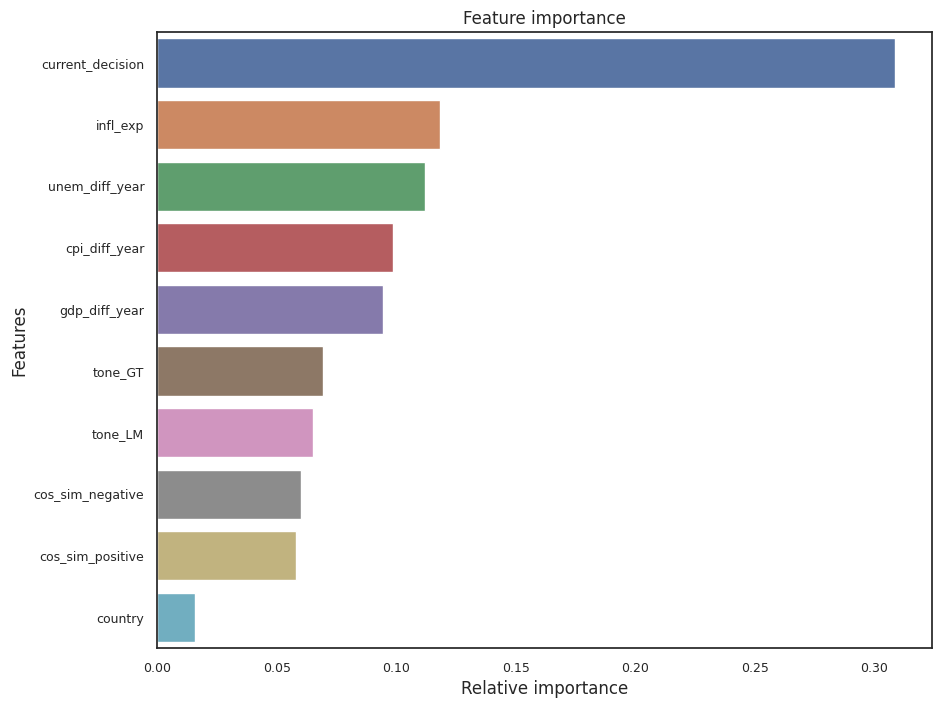

In [226]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")